In [ ]:
# download files  
!wget -nc https://scicomp.gw.observer/view/Final/NGC6397-1.dat                       # confident NGC6397 stars
!wget -nc https://scicomp.gw.observer/view/Final/gaia-NGC6397-neighborhood.csv       # stars near NGC6397 
!wget -nc https://scicomp.gw.observer/view/Final/NGC6397_iso.csv                     # isochrones

In [1]:
# import packages
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import layers

# load files
NGC6397 = pd.read_fwf('NGC6397-1.dat', names = ['source_id', 'ra', 'dec', 'phot_g_mean_mag'])
iso = pd.read_csv('NGC6397_iso.csv')
gaia = pd.read_csv('gaia-NGC6397-neighborhood.csv')

# PART 1
# make an classifer to cross-match data files
NGC6397_sel = gaia['source_id'].isin(NGC6397['source_id'])

In [10]:
#len(gaia), len(NGC6397)
#len(gaia[NGC6397_sel]), len(gaia[~NGC6397_sel])
#gia # NGC6397

(21772, 274784)

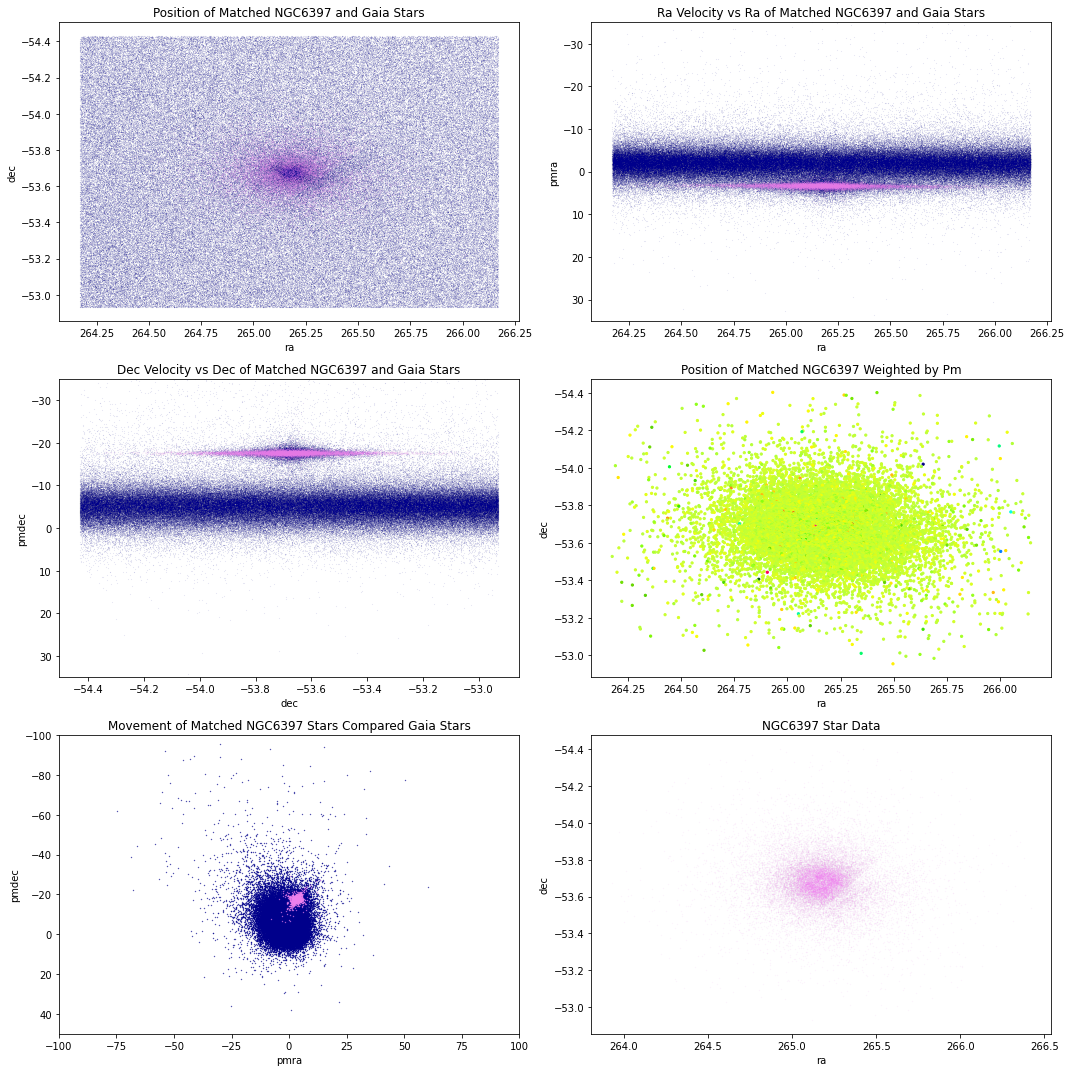

In [2]:
# explore the data sets 
fig, ax = plt.subplots(3, 2, figsize = (15, 15))

ax[0, 0].scatter(gaia['ra'][~NGC6397_sel], gaia['dec'][~NGC6397_sel], s = 0.001, color = 'darkblue')
ax[0, 0].scatter(gaia['ra'][NGC6397_sel], gaia['dec'][NGC6397_sel], s = 0.001, color = 'violet')
ax[0, 0].set_xlabel('ra')
ax[0, 0].set_ylabel('dec')
ax[0, 0].set_title('Position of Matched NGC6397 and Gaia Stars')
ax[0, 0].invert_yaxis()

ax[0, 1].scatter(gaia['ra'][~NGC6397_sel], gaia['pmra'][~NGC6397_sel], s = 0.001, color = 'darkblue')
ax[0, 1].scatter(gaia['ra'][NGC6397_sel], gaia['pmra'][NGC6397_sel], s = 0.001, color = 'violet')
ax[0, 1].set_xlabel('ra')
ax[0, 1].set_ylabel('pmra')
ax[0, 1].set_ylim(-35, 35)
ax[0, 1].set_title('Ra Velocity vs Ra of Matched NGC6397 and Gaia Stars')
ax[0, 1].invert_yaxis()

ax[1, 0].scatter(gaia['dec'][~NGC6397_sel], gaia['pmdec'][~NGC6397_sel], s = 0.001, color = 'darkblue')
ax[1, 0].scatter(gaia['dec'][NGC6397_sel], gaia['pmdec'][NGC6397_sel], s = 0.001, color = 'violet')
ax[1, 0].set_xlabel('dec')
ax[1, 0].set_ylabel('pmdec')
ax[1, 0].set_ylim(-35, 35)
ax[1, 0].set_title('Dec Velocity vs Dec of Matched NGC6397 and Gaia Stars')
ax[1, 0].invert_yaxis()

ax[1, 1].scatter(gaia['ra'][NGC6397_sel], gaia['dec'][NGC6397_sel], s = 5., 
                 c = gaia['pm'][NGC6397_sel], cmap = 'gist_ncar')
ax[1, 1].set_xlabel('ra')
ax[1, 1].set_ylabel('dec')
ax[1, 1].set_title('Position of Matched NGC6397 Weighted by Pm')
ax[1, 1].invert_yaxis()

ax[2, 0].scatter(gaia['pmra'][~NGC6397_sel], gaia['pmdec'][~NGC6397_sel], s = 0.1, color = 'darkblue')
ax[2, 0].scatter(gaia['pmra'][NGC6397_sel], gaia['pmdec'][NGC6397_sel], s = 0.1, color = 'violet')
ax[2, 0].set_xlabel('pmra')
ax[2, 0].set_xlim(-100, 100)
ax[2, 0].set_ylabel('pmdec')
ax[2, 0].set_ylim(-100, 50)
ax[2, 0].set_title('Movement of Matched NGC6397 Stars Compared Gaia Stars')
ax[2, 0].invert_yaxis()

ax[2, 1].scatter(NGC6397['ra'], NGC6397['dec'], s = 0.001, color = 'violet')
ax[2, 1].set_title('NGC6397 Star Data')
ax[2, 1].set_xlabel('ra')
ax[2, 1].set_ylabel('dec')
ax[2, 1].invert_yaxis()

plt.tight_layout()

I began by looking at both the NGC6397 and the Gaia data sets to see how they were organized and what each column was. To explore the data I first plotted the sky postions of all of the stars in the Gaia data set with the stars that also belong to the NGC6397 cluster overlaid; refer to the plot titled 'Position of Matched NGC6397 and Gaia Stars'. After understanding the sky positions of the cluster in question, I wanted to see how NGC6397 moves compared to the rest of the stars so I plotted the movement variables specific to each direction, pmra and pmdec, along with their respective postions. The plots, 'Ra Velocity vs Ra of Matched NGC6397 and Gaia Stars' and 'Dec Velocity vs Dec of Matched NGC6397 and Gaia Stars', show how the NGC6397 cluster moves in each direction. These plots highlight that the cluster has a small postive movement in right ascention compared to its neighbors, but it has significant negative movement in declenation compared to its neighbors. The next plot, 'Position of Matched NGC6397 Weighted by Pm', looks at the sky postion of just the  NGC6397 cluster weighted by the cluster's overall movement through the sky, and this plot shows that most of the stars in the NGC6397 move at the same speed while a small handful of stars in the cluster move at a different speed compared to the rest of the cluster. The next plot examines the relative movement of the NGC6397 cluster compared to all of the stars in the neighborhood, and this plot confirms what the other plots show: the NGC6397 cluster has very distinct movement compared to the neighboring stars which move very little over time, and this movement is small and postive in right ascention but large and negative in declenation. Because there is distinct movement of the  NGC6397 cluster compared to its neighbors in right ascention and declenation, pmra and pmdec will be useful to distinguish the cluster from the background stars. I will also include the pm variable; I do not expect this variable to have a huge impact on the ability of my model to classify the  NGC6397 cluster, but because some stars in this cluster move at different speeds compared to the rest of the cluster, I will include this variable. To check how this variable effects the model I will run the model without using pm and compare the results. The best fit will be the version that I use. The final plot above, "NGC6397 Star Data", looks at just the confidently identifed NGC6397 cluster because, after crossmatching catalgues using my selector I noticed that the Gaia catalogue only contains 21772 of the 22116 stars in the  NGC6397 catalogue, and I wanted to see the full NGC6397 cluster.

In [2]:
# prepare data 
params = ['ra', 'dec', 'pm', 'pmra', 'pmdec', 'bp_rp', 'phot_g_mean_mag']      # choose parameters for training and testing the model                              # 
gaia_new = np.array(gaia[params])                  # 'bp_rp', 'phot_g_mean_mag'

NA = np.any(np.isnan(gaia_new), axis = 1)           # remove empty entries from only parameter columns
gaia_new = gaia_new[~NA]

scalar = StandardScaler()                           # make sure all data values are scalars                                                      
gaia_new = scalar.fit_transform(gaia_new)

# create an input training and testing set
size = gaia_new.shape[0]                           
test_frac = 0.1

test_sel = np.random.choice([True, False], size = size, p = [test_frac, 1-test_frac])

input_train = gaia_new[~test_sel]
input_test = gaia_new[test_sel]

# create output training and testing data
output = np.column_stack([~NGC6397_sel, NGC6397_sel]).astype(int)[~NA]

output_train = output[~test_sel]
output_test = output[test_sel]

# create network layers
net = tf.keras.Sequential()

net.add(layers.Flatten(input_shape = gaia_new.shape[1:]))
net.add(layers.Dense(10, activation = 'relu'))
net.add(layers.Dense(10, activation = 'relu'))
net.add(layers.Dense(10, activation = 'relu'))
net.add(layers.Dense(output.shape[1], activation = 'softmax'))

net.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

# train and test the network
model_info = net.fit(input_train, output_train, batch_size = 15, epochs = 10, verbose = 0, 
                     validation_data = (input_test, output_test))

info = model_info.history

2022-06-08 23:51:18.205212: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-06-08 23:51:18.205658: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-08 23:51:18.205871: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (a0d54ff093fd): /proc/driver/nvidia/version does not exist
2022-06-08 23:51:18.217883: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-08 23:51:18.714814: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of t

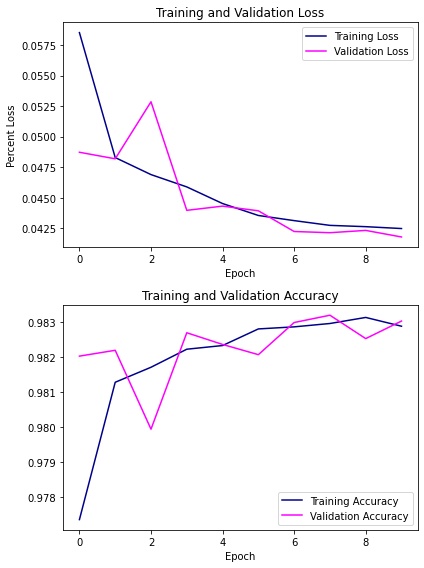

In [5]:
# visualize the training 
fig, ax = plt.subplots(2, 1, figsize = (6, 8))

# look at the learning loss compared to the validation loss
ax[0].plot(info['loss'], color = 'darkblue', label = 'Training Loss')
ax[0].plot(info['val_loss'], color = 'magenta', label = 'Validation Loss')
ax[0].set_title('Training and Validation Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Percent Loss')
ax[0].legend();

# look at the learning accuracy compared to the validation accuracy
ax[1].plot(info['accuracy'], color = 'darkblue', label = 'Training Accuracy')
ax[1].plot(info['val_accuracy'], color = 'magenta', label = 'Validation Accuracy')
ax[1].set_title('Training and Validation Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel;('Percent Accuracy')
ax[1].legend();

plt.tight_layout()

In [4]:
# predict NGC6397 stars using the test set
class_pred = net.predict(input_test)

NGC6397_pred = np.argmax(class_pred, axis = 1)

# get the testing accuracy
test_ac = net.evaluate(input_test, output_test, batch_size = 15)

1593/1593 [==============================] - 3s 2ms/step - loss: 0.0418 - accuracy: 0.9830


In [ ]:
# confirm that I have potential NGC6397 stars
plt.hist(class_pred[:,1], color = 'mediumturquoise')
plt.title('Probability of an NGC6397 Star')
plt.xlabel('Probability')
plt.ylabel('Counts');

In [ ]:
len(class_pred), len(input_test)

In [6]:
# save all misclassified test inputs to arrays
prob = []
new_prob = []

clas = []
new_class = []

test = []
new_test = []

best = []
new_best = []

truth = []
new_truth= []

for j in range(len(input_test)):                             # find all misclassified inputs              
    best_guess = np.argmax(class_pred[j])            

    if best_guess != output_test[j][1]:                           
        for i, p in enumerate(class_pred[j]):        
            prob.append(np.round(p*100, 2))             
            clas.append(i)
        
        best.append(best_guess)
        truth.append(output_test[j])
        test.append(input_test[j]) 
    
    if (best_guess == 1) & (output_test[j][1] == 0):         # find potential new cluster members 
        for i, p in enumerate(class_pred[j]):        
            new_prob.append(np.round(p*100, 2))  
            new_class.append(i)
           
        new_best.append(best_guess)
        new_truth.append(output_test[j])
        new_test.append(input_test[j])

# create data frames for all misclassified input
class_prob = {'class': clas, 'prob': prob}
cp = pd.DataFrame(class_prob)

guess = {'best_guess': best, 'truth': truth}
g = pd.DataFrame(guess)

t = pd.DataFrame(test)
t.columns = ['ra', 'dec', 'pm', 'pmra', 'pmdec', 'bp_rp', 'phot_g_mean_mag']      #'bp_rp', 'phot_g_mean_mag'    

# create data frames for potential new cluster members
new_class_prob = {'class': new_class, 'prob': new_prob}
ncp = pd.DataFrame(new_class_prob)

new_guess = {'best_guess': new_best, 'truth': new_truth}
ng = pd.DataFrame(new_guess)

new_test = scalar.inverse_transform(new_test)
new_t = pd.DataFrame(new_test)
new_t.columns = ['ra', 'dec', 'pm', 'pmra', 'pmdec', 'bp_rp', 'phot_g_mean_mag']    #'bp_rp', 'phot_g_mean_mag' 

# make a selector to crossmatch Gaia data and potential new cluster members
new_t_sel = gaia['ra'].isin(new_t['ra'])

new_clust = gaia[new_t_sel]

# find the number of misclassified inputs with a probability greater than 50%
conf_misclass = np.count_nonzero(cp['prob'] > 50.00) 

print('The model misclassifies', len(cp)/2, 'stars.')
print('The model misclassifies', conf_misclass, 'star with a probability > 50%')
print('The model finds', len(ng), 'potential new cluster members')

The model misclassifies 405.0 stars.
The model misclassifies 405 star with a probability > 50%
The model finds 322 potential new cluster members


In [ ]:
gaia[NGC6397_sel]

,source_id,ra,dec,parallax,parallax_error,pm,pmra,pmra_error,pmdec,pmdec_error,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,bp_rp,dr2_radial_velocity,dr2_radial_velocity_error
193,5921314764954254976,265.491649,-54.171705,0.279625,0.115494,17.719591,3.332912,0.120109,-17.403323,0.104650,18.066181,18.500046,17.508700,0.991346,NaN,NaN
263,5921314837965552896,265.467599,-54.162637,0.322777,0.132130,18.141386,3.541601,0.116150,-17.792329,0.107218,17.750797,NaN,NaN,NaN,NaN,NaN
476,5921315078495777792,265.529163,-54.144426,0.433832,0.086020,18.105438,3.704280,0.087939,-17.722450,0.075450,17.402208,17.775629,16.872927,0.902702,NaN,NaN
524,5921315177271297920,265.489130,-54.142481,0.444584,0.208660,17.985151,3.532611,0.219385,-17.634805,0.189338,18.872566,19.442558,18.206413,1.236145,NaN,NaN
657,5921315349069845632,265.463435,-54.118608,0.454282,0.173114,18.772617,1.509342,0.176159,-18.711843,0.144611,18.474545,19.091196,17.716883,1.374313,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296477,5921777354406702720,265.296458,-53.493101,0.627651,0.440288,17.907510,2.687560,0.414057,-17.704688,0.355650,19.839025,20.241142,18.734354,1.506788,NaN,NaN
296482,5921777354406752768,265.288629,-53.482761,0.318078,0.198177,18.130405,3.476495,0.184813,-17.793977,0.161217,18.650309,19.199411,18.023573,1.175839,NaN,NaN
296489,5921777354406776704,265.276062,-53.482819,0.606074,0.426959,18.787674,3.551227,0.404073,-18.448996,0.354314,19.726648,20.405981,19.014627,1.391354,NaN,NaN
296520,5921777354424490368,265.279378,-53.478135,0.488418,0.208725,18.126648,3.730911,0.218666,-17.738536,0.181245,18.850256,19.416862,18.194443,1.222420,NaN,NaN


In [19]:
new_t

,ra,dec,pm,pmra,pmdec
0,265.534674,-54.164194,18.701157,4.010029,-18.266169
1,265.436730,-54.042520,17.901243,3.325389,-17.589665
2,264.275683,-53.787352,17.488527,3.132808,-17.205641
3,264.515828,-54.092926,18.002441,3.024514,-17.746555
4,265.029141,-54.084128,17.617323,2.984036,-17.362764
...,...,...,...,...,...
617,265.340076,-53.475289,17.901262,3.565899,-17.542507
618,265.333364,-53.469415,18.453485,3.918895,-18.032565
619,265.336071,-53.461536,18.492025,2.639653,-18.302656
620,265.336320,-53.459347,18.304321,2.677187,-18.107480


I choose to use a neural network to classify the two star populations because neural networks are well suited to classification and identifcation tasks, and I have no idea how the input parameters (ra, dec, pm, pmra, and pmdec) are related so a simple NN is a good place to start. Since I want a very simple NN as my starting point I choose to use a DNN to classify the star populations. I used a relu activation function because a relu function is well suited to binary classification, and I used a softmax output function because it is a very generalized, multidimensional function; I will not change these functions as I alter my model because the relu and softmax functions are ideal for this classification task. Since I wanted the simplest neural network I could build as my starting point, I choose to begin with one layer to flatten the data, one dense layer, and one layer to reshape the output data. I ran this model several times and achieved testing accuracies between 95% and 96%. This simple model is not confident about most of the stars that it classifies as NGC6397 because, of the 26080 stars that are predicted to be NGC6397, about 5000 are predicted to be NGC6397 with > 40% confidence, and most of the stars are classified as NGC6397 with < 10% confidence. This model also misclassifies around 1000 of the 26080 stars with > 50% of being an NGC6397 star which is a red flag that the model may be overfitting the data. Since I only have two classes I do not expected the DNN to have > 50% confidence that any given point is an NGC6397 star, but I would like to improve the number of stars that are classified with > 40% confidence, and I would like to improve the testing accuracy.

To try and increase the number of confidently classified stars and increase the testing accuracy of the model I added a single relu layer identical to the first. This model performs questionably better than the first because it has a consistent testing accuracy from two runs at 96%, but the model overfits the data more because 1024 stars are misclassified with > 50% confidence from each run. Once again, this model is not confident about the stars it does classify as NGC6397 because most of the stars are classified as NGC6397 with < 10% probability of actually being an NGC6397 star, but this model does slightly better than the first model because it is able to classify around 5000 stars with > 50% confidence. 

To see if I can get the model to perform any better I added a third relu layer identical to the first two. This model, after two runs, achieves a testing accuracy of 96%, and it misclassifies no more than 980 stars as belonging to the NGC6397 cluster with > 50% confidence. Like the first two models, this model is not very confident that the majority of the stars it identifies as belonging to NGC6397 actually do because > 20000 stars are classified as NGC6397 with < 10% confidence, but this model, on average is able to classify about 5000 stars as belonging to the cluster with > 50% confidence. Since this model misclassifies less stars than either of the other models and has comparable testing accuracy to the second model this is the best model I have run so far.

My model with three dense layers has performed the best so far, and using this model as a starting point, I made a new model with the parameter pm removed. I ran this version of the model several times and achieved a testing accuracy of 96%. This model, like all of the others, is not confident about most of the stars that are identifed as NGC6397 because > 20000 stars are classified as NGC6397 with < 10% confidence. This model does consistently classify about 5000 stars with > 50% confidence, and it only misclassifies no more than 975 stars each run.

Since the model with three dense layers and the pm parameter and the model with three dense layers and no pm parameter perform about the same I ran both models a third time to look specifically at the plots titled "Training and Validation Accuracy" and "Training and Validation Loss" to get a sense of how well each model learns before deciding on a final model. The model without pm, on its third run, misclassifies 990 inputs, and the testing accuracy exceeds the training accuracy frequently enough that there is concern that this model is significantly overfitting the data. Upon a third run of the model with pm, the model misclassifies 887 stars, and the validation accuracy consistently exceeds the training accuracy which means that this model is overfitting the data as much as the model without pm. Since both models equally overfit the data, but the model with pm misslcassifies the data, on average, less than the model without pm, the model with pm is my final model for classifying these populations.

In [7]:
# check what the model learns by looking at predictions
h = np.random.randint(len(input_test))

for i, p in enumerate(class_pred[h]):
    print(i, round(p*100, 2), '%')
    
best_guess = np.argmax(class_pred[h])
print('Best guess:', best_guess)

print("Truth class:", output_test[h])

0 100.0 %
1 0.0 %
Best guess: 0
Truth class: [1 0]


In [8]:
# make a horizontal shift to the inputs to check the model's predictive capabilities
k = np.random.randint(len(input_test))

x = input_test[k]
x = np.roll(x, 10000, axis=0)

pred = net.predict(x[np.newaxis, ...])

for i, p in enumerate(pred[0]):
    print(i, round(p*100, 2), '%')
    
best_guess = np.argmax(pred)
print('best guess:', best_guess)
print("Truth class:", output_test[k]);

0 100.0 %
1 0.0 %
best guess: 0
Truth class: [1 0]


None of the DNN models that I tried were significantly better than another which leads me to conclude that the results listed here are as good as a DNN can do on this data. The model I settled on has an average testing accuracy of 96%, and it consistently classifies ~ 5000 stars with > 50% confidence of belonging to the NGC6397 cluster. The model, in general, is not confident about its classifcations, however, because most of the stars that are classified as belonging to the cluster are classified with < 10% confidence. This model misclassifies between ~ 880 and 1000 stars each time, and, as the plot "Training and Validation Accuracy" shows, the training accuracy is consistently lower the validation accuracy which implies that this model is drastically overfitting the data. 

I have used position and change of postion variables to teach the DNN which stars belong to the NGC6397 cluster, and the model performs worse when the pm parameter is removed which is an indication that the model is actually using postion to classify the stars. To check this assumption I used my chosen model to make predictions, and I checked the predictions and the confidence of the prediction against the truth. Next I next made a horizontal shift to the test data and made new predictions, once again checking the prediction's confidence and the truth. A small horizontal shift does not effect the model's confidence or predictive capabilties, and a large shift greatly effects the model's confidence but not its predictive capabilities. This indicates that, to some extent, the model is learning the postions of the NGC6397 cluster since shifting the inputs affects the model's confidence, but since a shift does not change the model's predictions, the model is not just learning position; what else the model is learning is unclear.

On the last run of the model it misclassifies 988 stars, and it finds 782 possible new cluster candidates (misclassified points that are predicted to belong to the NGC6397 cluster but that, according to the test outputs, do not). Undoing the scalar transformation on the input test data that generated the misclassified points and comparing it to the crossmatched Gaia data shows that it is likely that these points are misclassfied because they have a large negative pmdec and a smaller positive pmra just like the crossmatched data. Because the misclassified stars behave similarly to the NGC6397 cluster and the cluster has distinct behavior compared to its neighbors, as seen in the plot "Movement of Matched NGC6397 Stars Compared Gaia Stars", it is reasonble to investigate these misclassified points as potential cluster candidates. 

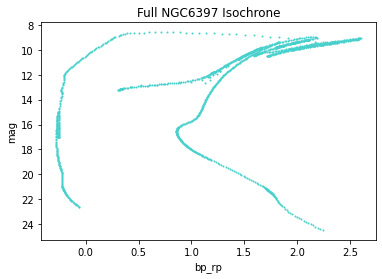

In [15]:
# PART 2
# plot the full isochrone
plt.scatter(iso['bp_rp'], iso['Gaia_G_EDR3'], s = 1, color = 'mediumturquoise')
plt.title('Full NGC6397 Isochrone')
plt.xlabel('bp_rp')
plt.ylabel('mag')
plt.gca().invert_yaxis();

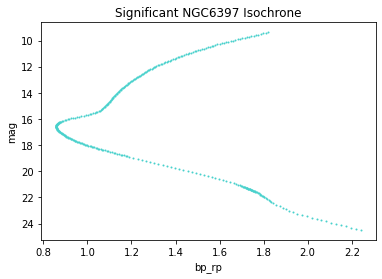

In [9]:
# select only desired evolutionary phases
phase = (iso['phase'] >= 0) & (iso['phase'] < 3)

# plot selected data 
plt.scatter(iso['bp_rp'][phase], iso['Gaia_G_EDR3'][phase], s = 1, color = 'mediumturquoise')
plt.title('Significant NGC6397 Isochrone')
plt.xlabel('bp_rp')
plt.ylabel('mag')
plt.gca().invert_yaxis();

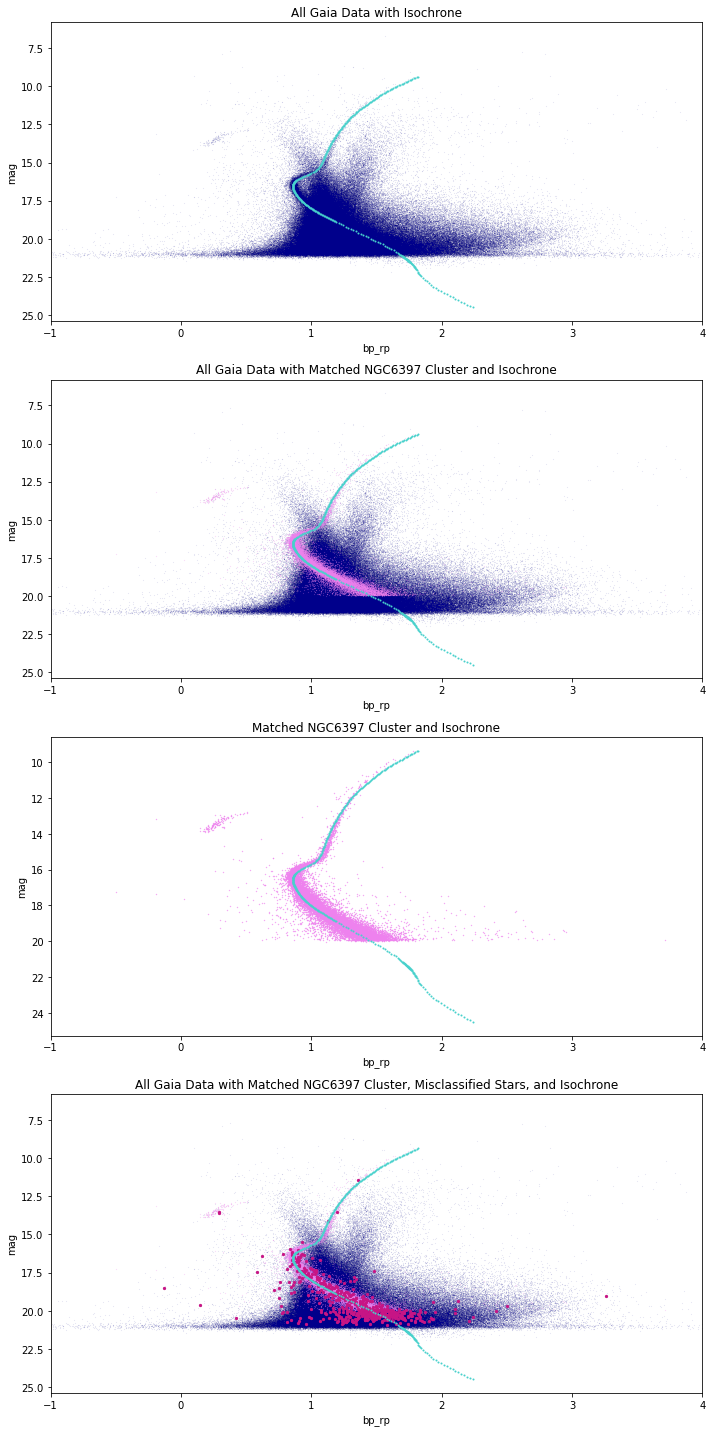

In [22]:
# plot Gaia data and cluster data with isochrone
fig, ax = plt.subplots(4, 1, figsize = (10, 20))

ax[0].scatter(gaia['bp_rp'], gaia['phot_g_mean_mag'], s = 0.001, color = 'darkblue')
ax[0].scatter(iso['bp_rp'][phase], iso['Gaia_G_EDR3'][phase], s = 1, color = 'mediumturquoise')
ax[0].set_title('All Gaia Data with Isochrone')
ax[0].set_xlabel('bp_rp')
ax[0].set_xlim(-1, 4)
ax[0].set_ylabel('mag')
ax[0].invert_yaxis()

ax[1].scatter(gaia['bp_rp'][~NGC6397_sel], gaia['phot_g_mean_mag'][~NGC6397_sel], s = 0.001, color = 'darkblue')
ax[1].scatter(gaia['bp_rp'][NGC6397_sel], gaia['phot_g_mean_mag'][NGC6397_sel], s = 0.01, color = 'violet')
ax[1].scatter(iso['bp_rp'][phase], iso['Gaia_G_EDR3'][phase], s = 1, color = 'mediumturquoise')
ax[1].set_title('All Gaia Data with Matched NGC6397 Cluster and Isochrone')
ax[1].set_xlabel('bp_rp')
ax[1].set_xlim(-1, 4)
ax[1].set_ylabel('mag')
ax[1].invert_yaxis()

ax[2].scatter(gaia['bp_rp'][NGC6397_sel], gaia['phot_g_mean_mag'][NGC6397_sel], s = 0.1, color = 'violet')
ax[2].scatter(iso['bp_rp'][phase], iso['Gaia_G_EDR3'][phase], s = 1, color = 'mediumturquoise')
ax[2].set_title('Matched NGC6397 Cluster and Isochrone')
ax[2].set_xlabel('bp_rp')
ax[2].set_xlim(-1, 4)
ax[2].set_ylabel('mag')
ax[2].invert_yaxis()

ax[3].scatter(gaia['bp_rp'][~NGC6397_sel], gaia['phot_g_mean_mag'][~NGC6397_sel], s = 0.001, color = 'darkblue')
ax[3].scatter(gaia['bp_rp'][NGC6397_sel], gaia['phot_g_mean_mag'][NGC6397_sel], s = 0.01, color = 'violet')
ax[3].scatter(new_clust['bp_rp'], new_clust['phot_g_mean_mag'], s = 5, color = 'mediumvioletred')
ax[3].scatter(iso['bp_rp'][phase], iso['Gaia_G_EDR3'][phase], s = 1, color = 'mediumturquoise')
ax[3].set_title('All Gaia Data with Matched NGC6397 Cluster, Misclassified Stars, and Isochrone')
ax[3].set_xlabel('bp_rp')
ax[3].set_xlim(-1, 4)
ax[3].set_ylabel('mag')
ax[3].invert_yaxis()

plt.tight_layout();

To assess whether or not the misclassified stars are viable cluster candidates I used the plot "All Gaia Data with Matched NGC6397 Cluster, Misclassified Stars, and Isochrone" to look at where the misclassified stars fall along the isochrone. I expect viable potential cluster candidates to not only move like the cluster, but I expect them to age like the cluster also which means that viable cluster candidates will follow the isochrone in a similar manner as the confidently identifed cluster members. The majority of the points that the model misclassifies are very scattered throughout the Gaia data and do not follow the isochrone so most of the potential new cluster members that the model finds are not viable; this is not surprising because the model has already been shown to overfit the data. It does appear that some of the misclassified points do follow the isochrone, however, and these stars, since they age and move like the cluster, are worth investigating further as viable cluster candiates. 

*I ran the DNN in Part 1, with the parameters bp_rp and magnitude included, to obtain the results discussed below. For visualuzation of the results discussed below please refer to the plots and cell output for Part 1 with the appropriate parameter cut.*


After adding in color and magnitude the model performed, overall, as I expected: the additional parameters cause the model to continue to overfit the data because repeated runs of the model frequently cause the validation accuracy to exceed the training accuracy, but the training accuracy for this model is high and consistent around 98% compared to the versions of the model without the additional parameters which could not achieve a testing acurracy above 96%. This model consistently has > 60% confidence for ~ 5000 points that it classifies as cluster members which is also better than any model so far, and this model misclassifies about half of the inputs it did without the additional parameters. This model also finds about half as many confidently identified potential cluster candidates as it did without the additional parameters.

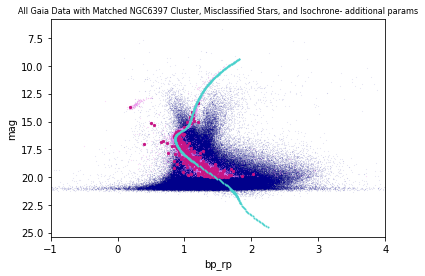

In [12]:
# plot the misclassified points, matched data, all Gaia data, and isochrone
plt.scatter(gaia['bp_rp'][~NGC6397_sel], gaia['phot_g_mean_mag'][~NGC6397_sel], s = 0.001, color = 'darkblue')
plt.scatter(gaia['bp_rp'][NGC6397_sel], gaia['phot_g_mean_mag'][NGC6397_sel], s = 0.01, color = 'violet')
plt.scatter(new_clust['bp_rp'], new_clust['phot_g_mean_mag'], s = 5, color = 'mediumvioletred')
plt.scatter(iso['bp_rp'][phase], iso['Gaia_G_EDR3'][phase], s = 1, color = 'mediumturquoise')
plt.title('All Gaia Data with Matched NGC6397 Cluster, Misclassified Stars, and Isochrone- additional params', size = 8)
plt.xlabel('bp_rp')
plt.xlim(-1, 4)
plt.ylabel('mag')
plt.gca().invert_yaxis()

Adding in color an magnitude not only creates a better classifier, but the misclassified points that are potential new cluster candidates now fall along the isochrone in a very similar pattern to the crossmatched data. These misclassified stars are viable new cluster candidates, unlike the previous model that had some potentially viable new cluster candidates but mostly misclassified points incorrectly.

In [2]:
# 510 PART
# import packages
from scipy.special import expit
from scipy.optimize import minimize

# prepare data 
params2 = ['ra', 'dec', 'pm', 'pmra', 'pmdec',              # choose model parameters 
           'bp_rp', 'phot_g_mean_mag'] 
gaia_new2 = np.array(gaia[params2])                  

NA2 = np.any(np.isnan(gaia_new2), axis = 1)                 # remove empty entries from only parameter columns
gaia_new2 = gaia_new2[~NA2]

scalar = StandardScaler()                                   # make sure all data values are scalars                                                      
gaia_new2 = scalar.fit_transform(gaia_new2)

# create input training data
X = np.column_stack((np.ones(len(gaia_new2)), gaia_new2))

# create output training data
y = NGC6397_sel.to_numpy(dtype = int)[~NA2]
y = y.reshape(-1, 1)

# perform logistic regression
# write a cost function
def cost(theta, X = X, y = y):
    m = y.size
    h = expit(X.dot(theta))
    J = -1/m * (y.T.dot(np.log(h)) + (1 - y).T.dot(np.log(1 - h)))
    J = J[0]
    
    if np.isnan(J):
        return np.inf
    
    return J

# write a gradient function and reshape data
def cost_gradient(theta, X = X, y = y):
    m = y.size
    h = expit(X.dot(theta.reshape(-1, 1)))
    gradient = 1/m * X.T.dot(h - y)
    
    return gradient.flatten()

In [3]:
# define the starting vector
theta0 = np.zeros(X.shape[1])

# minimize the regression 
res = minimize(cost, theta0, method = None, jac = cost_gradient, options = {'maxiter':400})

# make predictions 
opt = res.x.reshape((-1, 1))

def h(X, theta = opt):
    return expit(X.dot(theta))

def predict(X, theta = opt, threshold = 0.5):
    p = h(X, theta) >= threshold
    return p.astype('int')

p = predict(X)

# assess the model's performance
print('Training accuracy:', np.round(100 * np.count_nonzero(p == y)/p.size, 2), '%' )
print('Total predicted NCG6397 stars:', np.count_nonzero(p == 1))
print('Total misclassified stars:', np.count_nonzero(p != y))
print('Potential new cluster candidates:', np.count_nonzero(p == 1) & np.count_nonzero(p != y))

/tmp/ipykernel_58/1513178719.py:29: RuntimeWarning: divide by zero encountered in log
  J = -1/m * (y.T.dot(np.log(h)) + (1 - y).T.dot(np.log(1 - h)))
/tmp/ipykernel_58/1513178719.py:29: RuntimeWarning: divide by zero encountered in log
  J = -1/m * (y.T.dot(np.log(h)) + (1 - y).T.dot(np.log(1 - h)))
/tmp/ipykernel_58/1513178719.py:29: RuntimeWarning: divide by zero encountered in log
  J = -1/m * (y.T.dot(np.log(h)) + (1 - y).T.dot(np.log(1 - h)))
/tmp/ipykernel_58/1513178719.py:29: RuntimeWarning: divide by zero encountered in log
  J = -1/m * (y.T.dot(np.log(h)) + (1 - y).T.dot(np.log(1 - h)))
/tmp/ipykernel_58/1513178719.py:29: RuntimeWarning: divide by zero encountered in log
  J = -1/m * (y.T.dot(np.log(h)) + (1 - y).T.dot(np.log(1 - h)))
/tmp/ipykernel_58/1513178719.py:29: RuntimeWarning: divide by zero encountered in log
  J = -1/m * (y.T.dot(np.log(h)) + (1 - y).T.dot(np.log(1 - h)))


Training accuracy: 95.96 %
Total predicted NCG6397 stars: 26778
Total misclassified stars: 9803
Potential new cluster candidates: 8202


In [32]:
# compare the output of this model to the DNN
print('The percentage of misclassified stars from the DNN is:', np.round(100*conf_misclass/len(input_test), 2), '%')
print('The percentage of misclassified stars from the log regression is:', np.round(100*9803/len(p), 2), '%')

The percentage of misclassified stars from the DNN is: 1.7 %
The percentage of misclassified stars from the log regression is: 4.04 %


I used a logistic regression model as my second classifer because the sigmoid function used in a logistic regression is a function that only grows between 0 and 1 which is how I want to classify my binary data. As my training input I use the entire Gaia data set, and as the output function I use a one dimensional array of the crossmatched Gaia and NGC6397 data. A 1 in the output array, and consequently the model predictions, denotes that the data belongs to the cluster and a 0 denotes that the data belongs to the background stars. This model has a training accuracy of 95.96%, and the DNN has a training accuracy of about 98% when trained on ra, dec, pm, pmra, pmdec, bp_rp, and phot_g_mean_mag so the DNN performs better than a logistic regression model does at classifying this data. This model also misclassifies 4% of the stars it tests on compared to the 1.7% misclassification rate of the DNN. This model is less reliable than the DNN, and it is even less clear what the model is learning here than it is for the DNN becaue this model misclassifies so many additional stars. 

One way to include information from the isochrone in the model is to train on bp_rp and magnitude. Some of the confidently identified cluster members have evolved away from the main sequence, and they have very distinct postions on the Gaia HR plots, see the HR plots for Part 2. Including these parameters for the model to train on encodes the evolutionary information about the cluster into the model, thereby using the isochrone to enhance the model. 